Connected to Python 3.10.11

### Load libraries

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd

# Directly import helper function
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from utils import add_src_to_path
add_src_to_path()

from data_split import split_time_series_by_river
from rf_model import train_and_apply_rf_with_tuning
from plot_predictions import plot_predictions_by_river
from plot_predictions import plot_actual_vs_predicted

### Select River system and load dataset

In [2]:
# Choose from "Bristol Bay", "Fraser River" and "Columbia River"
river_system = "Bristol Bay"

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))  # assumes notebook is in /notebooks
data_path = os.path.join(project_root, 'data', 'Combined_FeatureSet_For_Model.csv')

combined_df = pd.read_csv(data_path)
# Optional: Select river system
combined_df = combined_df[combined_df["System"] == river_system]
# Optional: Select river
combined_df = combined_df[combined_df["River"] == "Alagnak"]


In [3]:
# Optional: Add additional feature
if True:
    combined_df = combined_df.sort_values(by=['System', 'River', 'Year'])
    combined_df["Total_Returns_1"] = combined_df.groupby(['System', 'River'])['Total_Returns'].shift(1)
    combined_df["Total_Returns_2"] = combined_df.groupby(['System', 'River'])['Total_Returns'].shift(2)
    combined_df["Total_Returns_3"] = combined_df.groupby(['System', 'River'])['Total_Returns'].shift(3)
    combined_df["Total_Returns_4"] = combined_df.groupby(['System', 'River'])['Total_Returns'].shift(4)
    combined_df["ao_mean_DecMar_1"] = combined_df.groupby(['System', 'River'])['ao_mean_DecMar'].shift(1)


### Check for missing data and remove columns with missing data

In [4]:
# Optional: Keep Spawner data and remove river Ugashik and first four year (1963-1966) 
# as no data available 
if True:
    combined_df = combined_df.dropna(subset=['total_spawners_y_minus_2_to_4'])

In [5]:
missing_summary = combined_df.isnull().sum()
missing_cols = missing_summary[missing_summary > 0]
print("Columns with missing values:\n")
print(missing_cols)

combined_df = combined_df.drop(columns=missing_cols.index)

Columns with missing values:

mei_mean_AprSep          12
sst_aprjul               17
sst_anom                 17
mean_temp_JunAug         57
mean_temp_MaySep         57
max_temp_JunAug          57
mean_discharge_MarMay    57
max_discharge_AprSep     57
dtype: int64


### Split data

In [6]:
train_df, test_df = split_time_series_by_river(
    combined_df,
    time_column="Year",
    group_columns=["System", "River"],
    test_fraction=0.2,
    gap_years=0  # Set to 1 if you want a 1-year gap between train and test
)

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (46, 40)
Test shape: (11, 40)


### One-hot encode the 'River' column

In [7]:
train_df["River_Name"] = train_df["River"] # For visualization
test_df["River_Name"] = test_df["River"]

train_df_encoded = pd.get_dummies(train_df, columns=["River"], prefix="River")
test_df_encoded = pd.get_dummies(test_df, columns=["River"], prefix="River")

### Train random forest with gridsearch hyperparameter tuning

In [8]:
results = train_and_apply_rf_with_tuning(train_df_encoded, test_df_encoded, topk_feat = 0)

Selected features:
Index(['Total_Returns', 'AgeClass_0.1', 'AgeClass_0.2', 'AgeClass_0.3',
       'AgeClass_0.4', 'AgeClass_0.5', 'AgeClass_1.1', 'AgeClass_1.2',
       'AgeClass_1.3', 'AgeClass_1.4', 'AgeClass_1.5', 'AgeClass_2.1',
       'AgeClass_2.2', 'AgeClass_2.3', 'AgeClass_2.4', 'AgeClass_3.1',
       'AgeClass_3.2', 'AgeClass_3.3', 'AgeClass_3.4', 'Pacea_ALPI_Anomaly',
       'npi_mean_NovMar', 'oni_mean_DecFeb', 'npgo_mean_DecFeb',
       'ao_mean_DecMar', 'pdo_mean_DecMar', 'pdo_mean_MaySep', 'sss_mayaug',
       'total_spawners_y_minus_2', 'total_spawners_y_minus_3',
       'total_spawners_y_minus_4', 'total_spawners_y_minus_2_to_4',
       'Total_Returns_1', 'Total_Returns_2', 'Total_Returns_3',
       'Total_Returns_4', 'ao_mean_DecMar_1', 'River_Alagnak'],
      dtype='object')
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest R2: -0.25
Random Forest MSE: 4288487963507.13
Random Forest MAPE: 42.71


### Optional: Fit ARIMA model on residuals (only works if only one river selected so far)

In [16]:
if True:    
    residuals = results["Timeline"]["Actual"] - results["Timeline"]["Predicted"]

    from statsmodels.tsa.arima.model import ARIMA
    residuals_series = pd.Series(residuals.values, index=results["Timeline"]["Year"])
    arima_model = ARIMA(residuals_series, order=(1,0,0))  # You may want to auto-tune this
    arima_fit = arima_model.fit()
    residual_forecast = arima_fit.forecast(steps=len(results["Timeline"]["Predicted"]))

    hybrid_pred = results["Timeline"]["Predicted"] + residual_forecast.values
    from sklearn.metrics import mean_squared_error, r2_score
    r2 = r2_score(results["Timeline"]["Actual"], hybrid_pred)
    print(r2)

    results["Timeline"]["Predicted"] = hybrid_pred

-0.07481122327345524


C:\Users\julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, 

### Performance metrics

In [10]:
results["Metrics_by_System"]

,System,R2,MSE,MAPE
0,Bristol Bay,-0.252317,4.288488e+12,42.714368


In [11]:
results["Metrics_by_River"]

,River_Name,R2,MSE,MAPE
0,Alagnak,-0.252317,4.288488e+12,42.714368


### Plot predictions

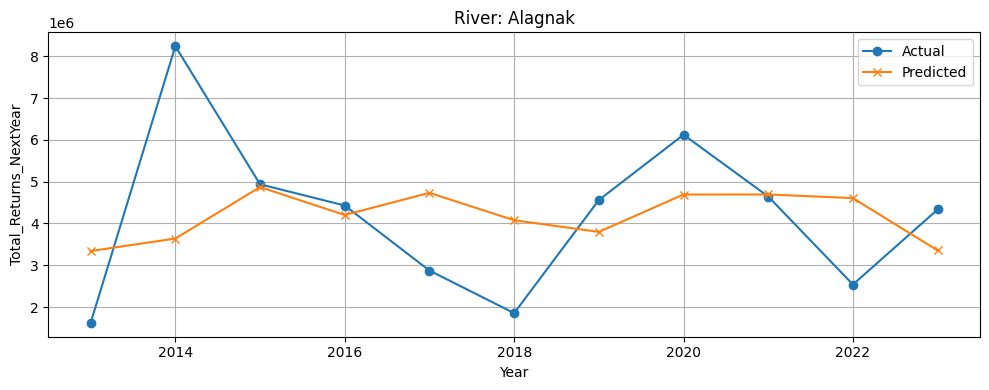

In [17]:
plot_predictions_by_river(results["Timeline"])

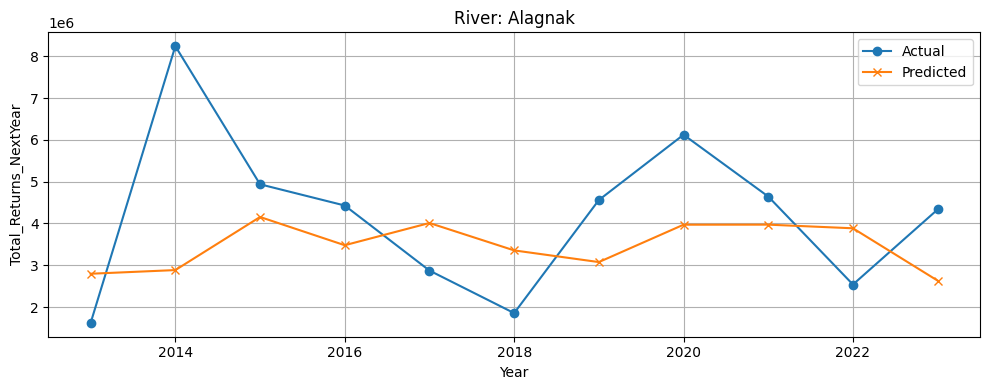

In [13]:
plot_predictions_by_river(results["Timeline"])

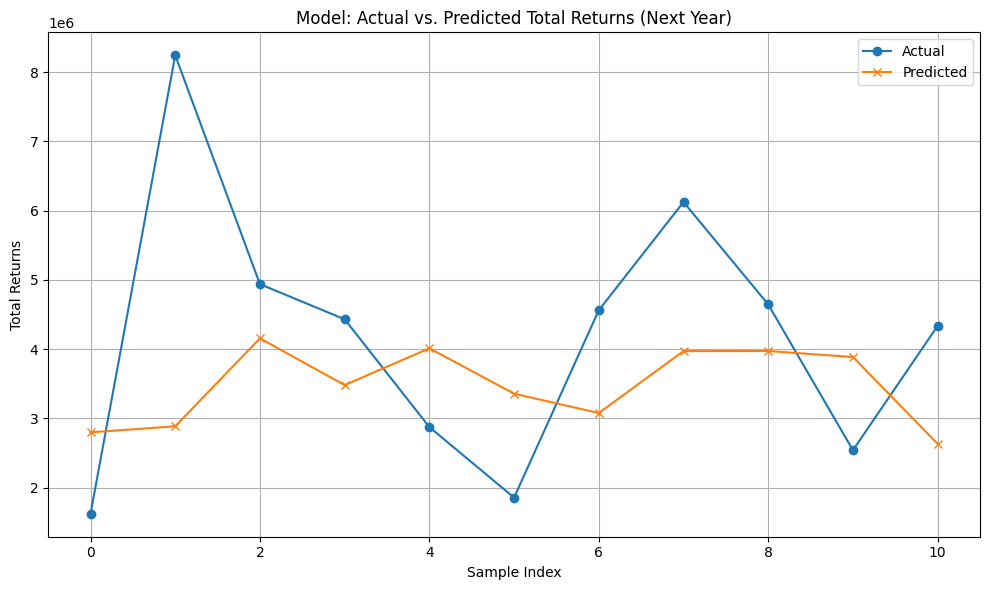

In [14]:
# Plot Predicted vs Actual
plot_actual_vs_predicted(results)

### Feature Importances

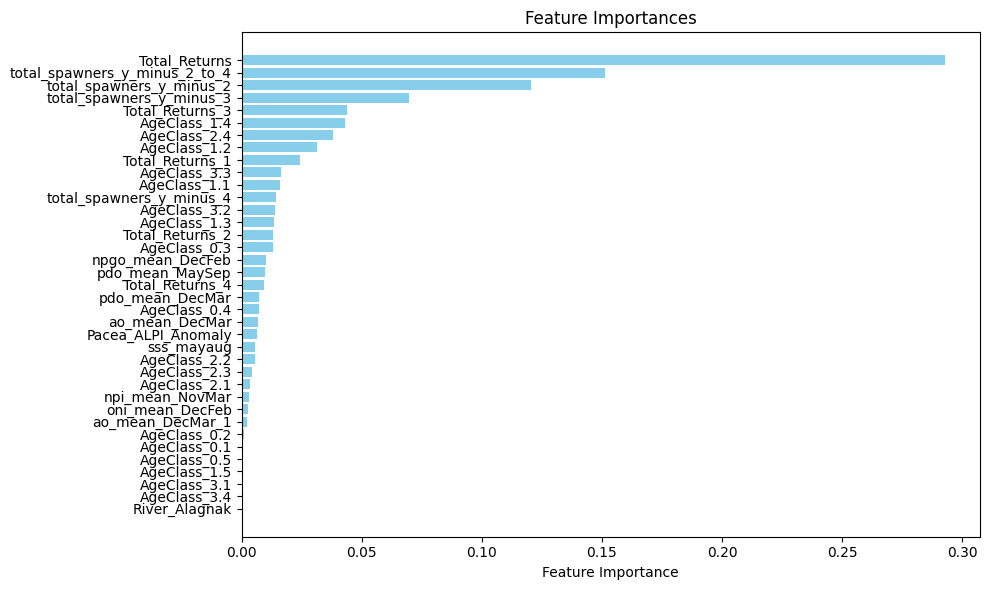

In [15]:
sorted_items = sorted(results["Feature_Importances"].items(), key=lambda x: x[1], reverse=True)
features, importances = zip(*sorted_items)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Most important on top
plt.tight_layout()
plt.show()